In [1]:
import torch
from torch import nn
from torchviz import make_dot, make_dot_from_trace
from torchsummary import summary

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # CNN - Bock 1
        self.conv_1_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.conv_1_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.maxpool_1 = nn.MaxPool2d(kernel_size=3)
        
        # CNN - Block 2
        self.conv_2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.conv_2_2 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.maxpool_2 = nn.MaxPool2d(kernel_size=3)
        
        # MLP
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 12)

    def forward(self, x):
        x = F.relu(self.maxpool_1(self.conv_1_2(self.conv_1_1(x))))
        x = F.relu(self.maxpool_1(self.conv_2_2(self.conv_2_1(x))))
        
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
model = CNNModel().to(device)

summary(model, (3, 135, 135))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 67, 67]           1,568
            Conv2d-2           [-1, 64, 33, 33]          32,832
         MaxPool2d-3           [-1, 64, 11, 11]               0
            Conv2d-4            [-1, 128, 5, 5]         131,200
            Conv2d-5             [-1, 64, 2, 2]         131,136
         MaxPool2d-6             [-1, 64, 1, 1]               0
            Linear-7                  [-1, 128]           8,320
            Linear-8                   [-1, 64]           8,256
            Linear-9                   [-1, 12]             780
Total params: 314,092
Trainable params: 314,092
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.21
Forward/backward pass size (MB): 1.72
Params size (MB): 1.20
Estimated Total Size (MB): 3.12
-------------------------------------------

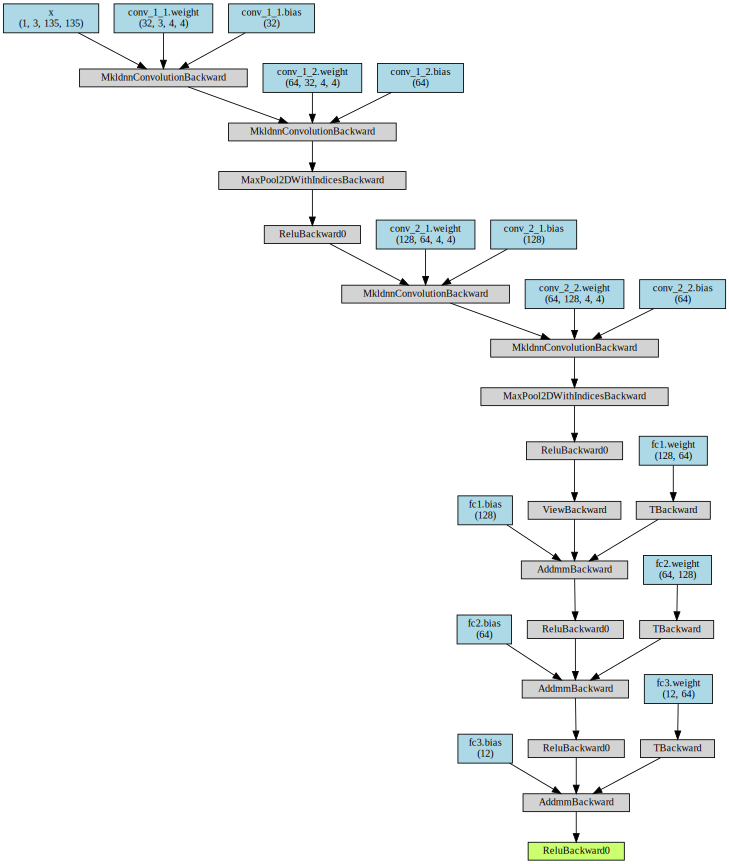

In [4]:
model = CNNModel()

x = torch.randn(1, 3, 135, 135).requires_grad_(True)
y = model(x)
make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)]))

In [5]:
with torch.onnx.set_training(model, False):
    trace, _ = torch.jit.get_trace_graph(model, args=(x,))
make_dot_from_trace(trace)

AssertionError: %32 : Long() = onnx::Mul(%25, %28)
 has empty scope name